Iter 001: Loss=0.0106, Δ=0.080078, L2_R=0.024861
Iter 002: Loss=0.0080, Δ=0.102539, L2_R=0.029954
Iter 003: Loss=0.0069, Δ=0.092407, L2_R=0.028549
Iter 004: Loss=0.0052, Δ=0.077244, L2_R=0.026730
Iter 005: Loss=0.0053, Δ=0.058990, L2_R=0.020676
Iter 006: Loss=0.0043, Δ=0.061035, L2_R=0.021067
Iter 007: Loss=0.0042, Δ=0.058594, L2_R=0.019331
Iter 008: Loss=0.0037, Δ=0.054810, L2_R=0.017293
Iter 009: Loss=0.0032, Δ=0.047607, L2_R=0.013452
Iter 010: Loss=0.0028, Δ=0.030762, L2_R=0.011004
Iter 011: Loss=0.0023, Δ=0.029785, L2_R=0.008960
Iter 012: Loss=0.0019, Δ=0.019714, L2_R=0.006170
Iter 013: Loss=0.0005, Δ=0.012329, L2_R=0.004029
Iter 014: Loss=-0.0002, Δ=0.005633, L2_R=0.001861
Iter 015: Loss=-0.0006, Δ=0.007751, L2_R=0.002447
Iter 016: Loss=-0.0014, Δ=0.016838, L2_R=0.005209
Iter 017: Loss=-0.0022, Δ=0.023438, L2_R=0.008361
Iter 018: Loss=-0.0033, Δ=0.031738, L2_R=0.010147
Iter 019: Loss=-0.0022, Δ=0.037109, L2_R=0.012867
Iter 020: Loss=-0.0054, Δ=0.055664, L2_R=0.017681
Iter 021: Los

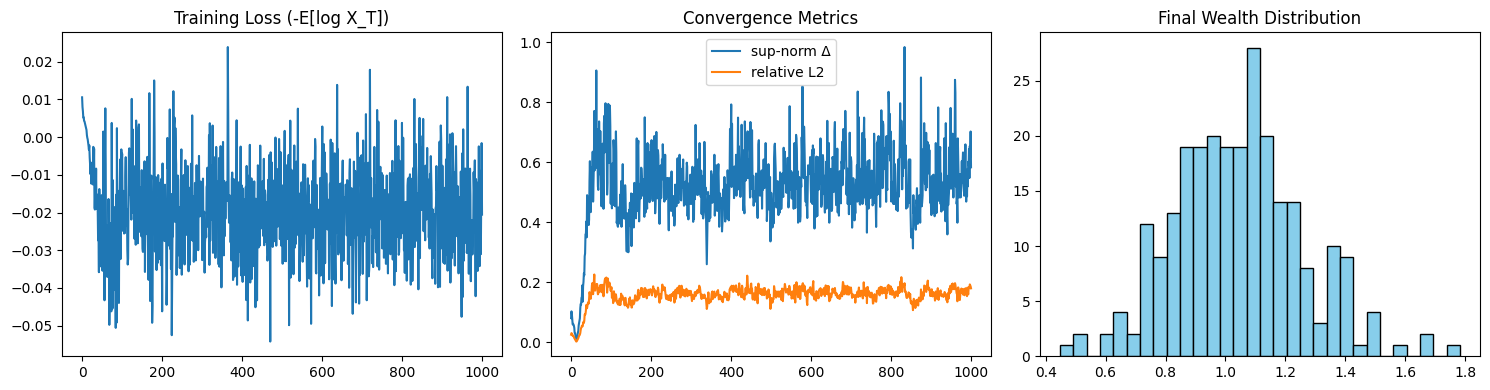

: 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import signatory
import matplotlib.pyplot as plt

# === Parameters ===
T = 1.0
K = 100
dt = T / K
N = 256           # number of agents
M = 2             # signature depth
mu, sigma_idio, sigma_common = 0.05, 0.2, 0.15
initial_wealth = 1.0
fictitious_rounds = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Time grid ===
time_grid = torch.linspace(0, T, K + 1)         \
               .unsqueeze(0).unsqueeze(2)       \
               .repeat(N, 1, 1).to(device)

# === Utility function ===
def utility(x):
    return torch.log(x + 1e-6)

# === Relative L2 helper ===
def rel_L2(curr, prev, dt):
    # curr, prev: numpy arrays shape [N, K+1]
    num = np.mean(np.sum((curr - prev)**2, axis=1) * dt)
    den = np.mean(np.sum(prev**2, axis=1) * dt)
    return np.sqrt(num/den)

# === Policy network ===
class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, t, x, m):
        return self.model(torch.cat([t, x, m], dim=1))

policy_net = PolicyNet().to(device)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-3)

# === Initial mean-field ===
mean_field = torch.full((N, K+1, 1), initial_wealth, device=device)

loss_history = []
delta_history = []
l2_history = []

for n in range(1, fictitious_rounds+1):
    # -- simulate Brownian motions --
    dW = torch.randn(N, K, 1, device=device) * np.sqrt(dt)
    dB = torch.randn(N, K, 1, device=device) * np.sqrt(dt)
    B = torch.cumsum(dB, dim=1)

    # -- record previous mean for L2 error --
    prev_mean = mean_field.squeeze(-1).cpu().numpy()  # [N, K+1]

    # -- compute signatures of (t, B_t) --
    path = torch.cat([time_grid[:, :-1], B], dim=2)   # [N, K, 2]
    sig = signatory.signature(path, depth=M)          # [N, sig_dim]

    # -- simulate wealth paths --
    X = torch.zeros(N, K+1, 1, device=device)
    X[:, 0, 0] = initial_wealth
    for k in range(K):
        t = time_grid[:, k]       # [N,1]
        x = X[:, k]               # [N,1]
        m = mean_field[:, k]      # [N,1]
        pi = policy_net(t, x, m)  # [N,1]
        dX = pi * (mu*dt + sigma_idio*dW[:,k] + sigma_common*dB[:,k])
        X[:, k+1] = x + dX

    # -- signature regression for mean-field update --
    y = X[:, -1, 0].detach().cpu().numpy()         # [N]
    Xmat = sig.detach().cpu().numpy()              # [N, sig_dim]
    coeffs = np.linalg.lstsq(Xmat, y, rcond=None)[0]# [sig_dim]
    y_pred = torch.tensor(Xmat.dot(coeffs),
                          dtype=torch.float32,
                          device=device)          # [N]
    y_pred = y_pred.view(N, 1, 1)                   # [N,1,1]
    new_mean = y_pred.expand(-1, K+1, -1)           # [N,K+1,1]

    # -- convergence metrics --
    delta = (mean_field - new_mean).abs().max().item()
    delta_history.append(delta)

    curr_mean = new_mean.squeeze(-1).cpu().numpy()  # [N,K+1]
    l2err = rel_L2(curr_mean, prev_mean, dt)
    l2_history.append(l2err)

    mean_field = new_mean

    # -- train policy (maximize log utility) --
    loss = -utility(X[:, -1, 0]).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    print(f"Iter {n:03d}: Loss={loss.item():.4f}, Δ={delta:.6f}, L2_R={l2err:.6f}")

# === Final Plots ===
fig, axes = plt.subplots(1, 3, figsize=(15,4))

axes[0].plot(loss_history)
axes[0].set_title("Training Loss (-E[log X_T])")

axes[1].plot(delta_history, label="sup-norm Δ")
axes[1].plot(l2_history, label="relative L2")
axes[1].set_title("Convergence Metrics")
axes[1].legend()

axes[2].hist(X[:, -1, 0].detach().cpu().numpy(),
             bins=30, color="skyblue", edgecolor="black")
axes[2].set_title("Final Wealth Distribution")

plt.tight_layout()
plt.savefig("output_base.png", dpi=150)   # this writes real PNG data!

plt.show()
